# Задача проекта

определить, какие птицы слышны на записях, сделанных в Western Ghats. Это важная задача для ученых, которые следят за популяциями птиц в целях их сохранения. Более точные решения могли бы обеспечить более комплексный мониторинг. 
Имеется 182 вида. Нужно будет предсказать вероятность присутствия каждой птицы для каждого ряда.

# Описание данных

**train_audio** Данные обучения состоят из коротких записей отдельных криков птиц, щедро загруженных пользователями xenocanto.org. Эти файлы были понижены до 32 кГц, где это применимо, чтобы соответствовать звуку тестового набора, и преобразованы в формат ogg. 
 
**test_soundscapes** Файлы для тестирования. Не содержат метки.

**train_metadata.csv** Для обучающих данных предоставляется широкий спектр метаданных. Наиболее важные поля:

   - *primary_label*: код вида птиц. Вы можете просмотреть подробную информацию о кодах птиц, добавив код к https://ebird.org/species/, например, https://ebird.org/species/amecroдля американской вороны. Не у всех видов есть свои страницы; некоторые ссылки не работают.
   - *latitude& longitude* : координаты места, где была сделана запись. Некоторые виды птиц могут иметь местные «диалекты», поэтому вы можете искать географическое разнообразие в своих обучающих данных.
   - *author*: пользователь, предоставивший запись.
   - *filename*: имя связанного аудиофайла.


**eBird_Taxonomy_v2021.csv** Данные о взаимоотношениях между разными видами.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import gc
import pathlib
from pathlib import Path

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colorama import Fore, Style, init
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd

import torchaudio
from tqdm import tqdm
from joblib import Parallel, delayed
import os

np.random.seed(12345)
random.seed(12345)

In [3]:
path = '/kaggle/input/birdclef-2024'

In [4]:
df = pd.read_csv(os.path.join(path, 'train_metadata.csv'))
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg


## DATA ANALYSIS

Для начала посмотрим распределение представленных видов птиц в разрезе их географического местонахождения.

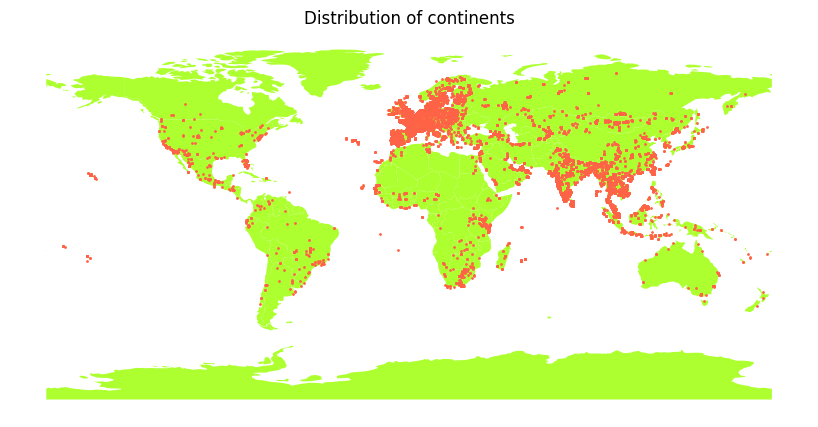

In [5]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(22,5), color='greenyellow')
ax.set_axis_off()
ax.set_title('Distribution of continents')
gdf.plot(ax=ax, marker='o', color='tomato', markersize=1)
plt.show()

Большая часть аудиозаписей - птицы из Европейских и Южных Азиатский стран.
Теперь изучим тоже самое, но в разрезе представленных видов птиц.

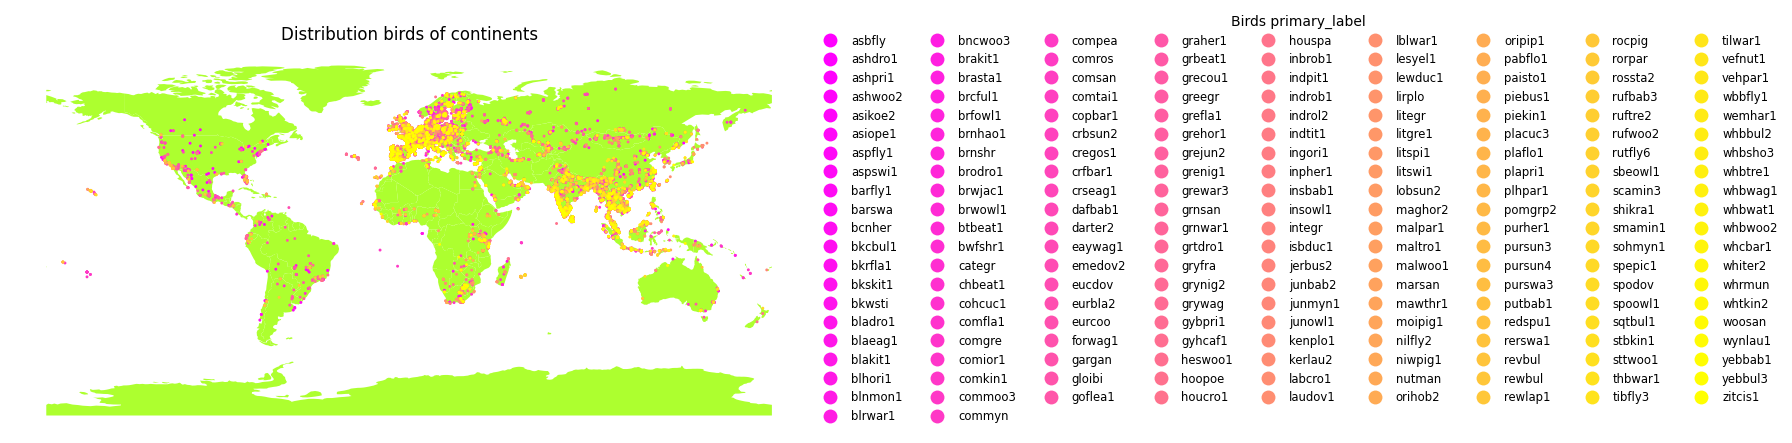

In [6]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(22,5), color='greenyellow')
gdf.plot(ax=ax, marker='o', column=df['primary_label'], cmap='spring', markersize=1.2, legend=True, 
         legend_kwds={'loc':'lower left', 'markerscale':1, 'ncols':9, 'frameon': False, 'title_fontsize':'medium', 'title': 'Birds primary_label', 'bbox_to_anchor':(1, 0., 0.5, 0.5),'fontsize':'small'})

ax.set_axis_off()
ax.set_title('Distribution birds of continents')
plt.show()

В данных колонки 'type' содежатся теги к аудиозаписям. В них отражена информация о половой и возрастной пренадлежности, а так же о звуках на записи. Выведем некоторые полезные признаки в отдельные колонки:
 - пол птицы (самка, самец, оба - для некоторых птиц, например снегирей, пение характерно для обоих полов)
 - возраст птицы (взрослая, птенец)
 - принадлежность птиц к группе ночных
 - песня или звук

Еще полезно будет некоторые звуки также разбить на группы. Возьмем наиболее часто встречаемые:
 - спаривания
 - тревоги
 - криков в полете

In [7]:
df['type'] = df['type'].apply(lambda x: x.lower())
df['gender'] = df['type'].apply(lambda x: 'female' if ('female' in x) and ('male' not in x) else 'male/female' if 'female' in x else 'male' if 'male' in x else 'unknow')
df['age'] = df['type'].apply(lambda x: 'adult' if 'adult' in x else 'juvenile' if 'juvenile' in x else 'unknow')
df['is_nigth'] = df['type'].apply(lambda x: 'yes' if 'nocturnal' in x else 'no')
df['is_song'] = df['type'].apply(lambda x: 'yes' if 'song' in x else 'no')
df['is_alarm'] = df['type'].apply(lambda x: 'yes' if 'alarm' in x else 'no')
df['is_sex'] = df['type'].apply(lambda x: 'yes' if ('sex' in x) or ('mating' in x) else 'no')
df['is_fligth'] = df['type'].apply(lambda x: 'yes' if 'flight' in x else 'no')

Добавим информацию о аудиозаписях:
 - количество фреймов
 - длительность в минутах
 - размер файла

In [8]:
metadatas = Parallel(n_jobs=os.cpu_count())\
                    (delayed(lambda filename: torchaudio.info(path+'/train_audio/' + filename))(filename) for filename in df.filename)

In [9]:
sig, sr = torchaudio.load(path+'/train_audio/' + df.filename.iloc[0])
bytes_per_sample = sig.element_size()

df['num_frames'] = [m.num_frames for m in metadatas]
num_samples = df['num_frames'].sum()
df['minutes'] = df['num_frames']/sr/ 60
df['size_Gbyte'] = df['num_frames']*bytes_per_sample/2**30

df.head(5)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,...,gender,age,is_nigth,is_song,is_alarm,is_sex,is_fligth,num_frames,minutes,size_Gbyte
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,...,unknow,unknow,no,no,no,no,no,875712,0.456100,0.003262
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,...,unknow,unknow,no,yes,no,no,no,506304,0.263700,0.001886
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,...,unknow,unknow,no,yes,no,no,no,936768,0.487900,0.003490
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,unknow,unknow,no,no,no,no,no,453184,0.236033,0.001688
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,unknow,unknow,no,no,no,no,no,1532288,0.798067,0.005708


In [10]:
def get_aggregation(df, column):
    df_ = df[column].value_counts(normalize=True).to_frame()\
                           .join(df.groupby(by=column)[['rating', 'minutes', 'size_Gbyte']].mean())\
                           .join(df[column].value_counts().to_frame())
    df_['group'] = df_['proportion'].apply(lambda x: 'small' if x<0.00025 else 'large' if x>0.01 else 'medium')
    return df_

Изучим данные в разрезе видов птиц.

In [11]:
df_pr = get_aggregation(df, 'primary_label')
df_pr.head()

,proportion,rating,minutes,size_Gbyte,count,group
primary_label,,,,,,
zitcis1,0.020442,3.738,0.529032,0.003784,500,large
lirplo,0.020442,3.698,0.572866,0.004097,500,large
litgre1,0.020442,3.730,0.421249,0.003013,500,large
comgre,0.020442,4.041,0.482255,0.003449,500,large
comkin1,0.020442,3.852,0.523728,0.003746,500,large


Изучим как представлены классы. В данных наблюдается сильный дисбаланс - присутсвует достаточно много видов птиц, выборки по которым меньше 30 аудиофайлов.

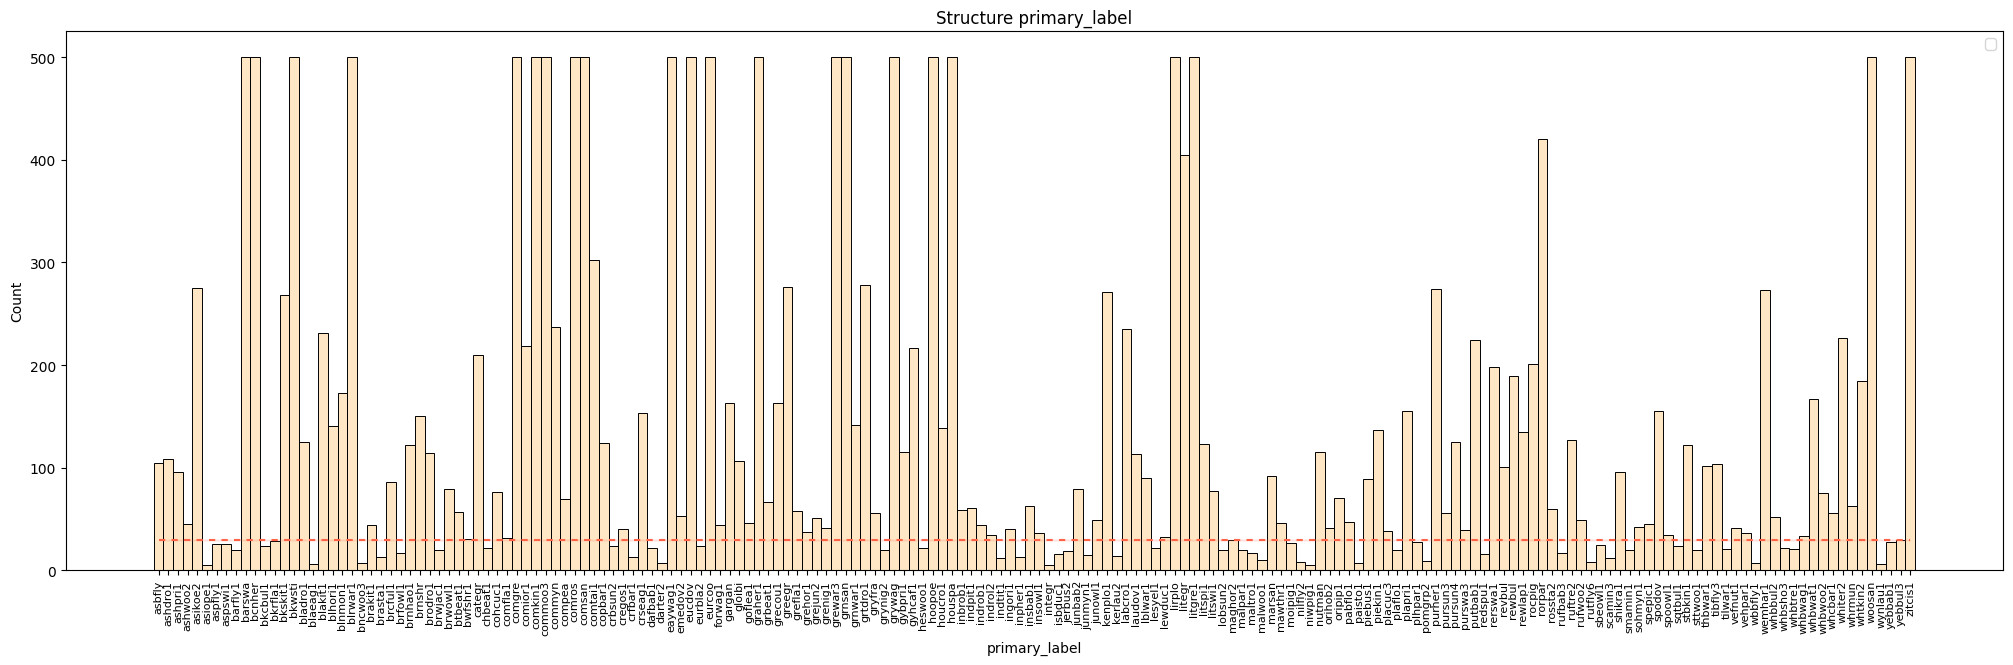

In [12]:
plt.figure(figsize=(25, 7))
sns.histplot(x = df['primary_label'], color='navajowhite', alpha = 0.7)
sns.lineplot(x = df['primary_label'], y=30, style=True, dashes=[(3,3)], color = 'tomato')
plt.xticks(fontsize=8, rotation=90)
plt.title('Structure primary_label')
plt.legend([])
plt.show()

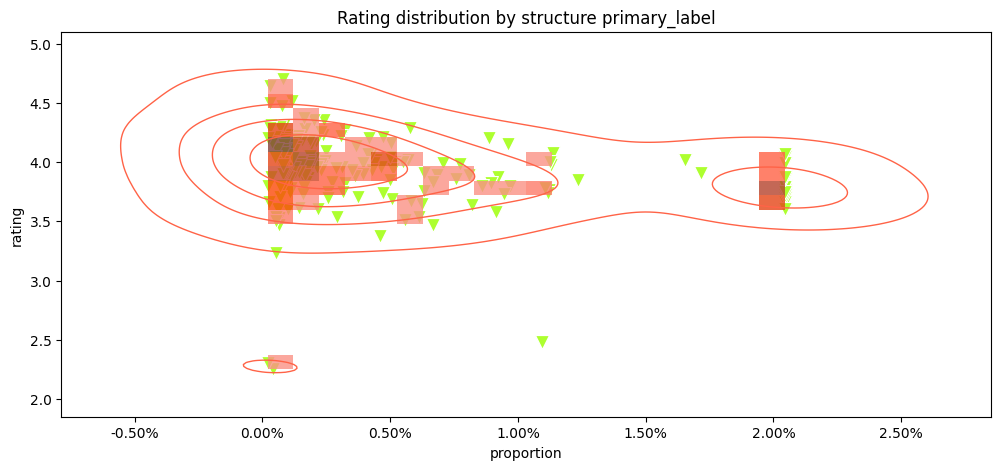

In [13]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_pr['proportion'], y=df_pr['rating'],  color='greenyellow', marker = 'v', s = 100)
sns.histplot(x=df_pr['proportion'], y=df_pr['rating'], bins=20, pthresh=.1, color='tomato', shrink=.8, alpha = 0.8)
sns.kdeplot(x=df_pr['proportion'], y=df_pr['rating'], levels=5, color='tomato', linewidths=1)
plt.gca().set_xticklabels([f'{x:.2%}' for x in plt.gca().get_xticks()]) 
plt.title('Rating distribution by structure primary_label')
plt.show()

Как видно из графика большинство классов в структуре выборки не превышает 0,5%. При этом не видно значимой зависимости между количеством представленных файлов и их рейтингом. 
Скорее всего рейтинг отражает соответствие звуков определенным классам птиц и/или качество аудиозаписей.

In [14]:
def show_aggregation_info(df, lim=None):
    plt.figure(figsize=(18, 11))
    
    ax = plt.subplot(2, 2, 1)
    flierprops = dict(marker='o', markerfacecolor='tomato', markersize=3, markeredgecolor='none')
    medianprops = dict(linestyle='--', linewidth=1.5, color='tomato')
    sns.boxplot(x=df['group'], y=df['rating'], color='greenyellow',  flierprops=flierprops, medianprops=medianprops)
    plt.axhline(df['rating'].mean(), color='yellow', linestyle = '--')
    plt.title(f'Distribution rating by group')
  
    ax = plt.subplot(2, 2, 3)
    sns.scatterplot(x = df['count'], y=df['minutes'], s = 150, hue=df['group'], size = df['rating'], palette=['violet', 'lawngreen', 'orange'])
    sns.kdeplot(x = df['count'], y=df['minutes'], levels=5, color='tomato', linewidths=1)
    if lim is not None:
        plt.ylim(0, lim)
    plt.title('Rating distribution by count')
    
    ax = plt.subplot(2, 2, 2)
    sns.boxplot(x=df['group'], y=df['minutes'], color='navajowhite',  flierprops=flierprops, medianprops=medianprops)
    plt.axhline(df['minutes'].mean(), color='yellow', linestyle = '--')
    if lim is not None:
        plt.ylim(0, lim)
    plt.title(f'Distribution minutes by group')
    
    ax = plt.subplot(2, 2, 4)
    sns.scatterplot(x = df['rating'], y=df['minutes'], s = 150, hue=df['group'], size = df['size_Gbyte'], palette=['violet', 'lawngreen', 'orange'])
    sns.kdeplot(x = df['rating'], y=df['minutes'], levels=5, color='tomato', linewidths=1)
    if lim is not None:
        plt.ylim(0, lim)
    plt.title('Rating distribution by time')
    
    plt.show()

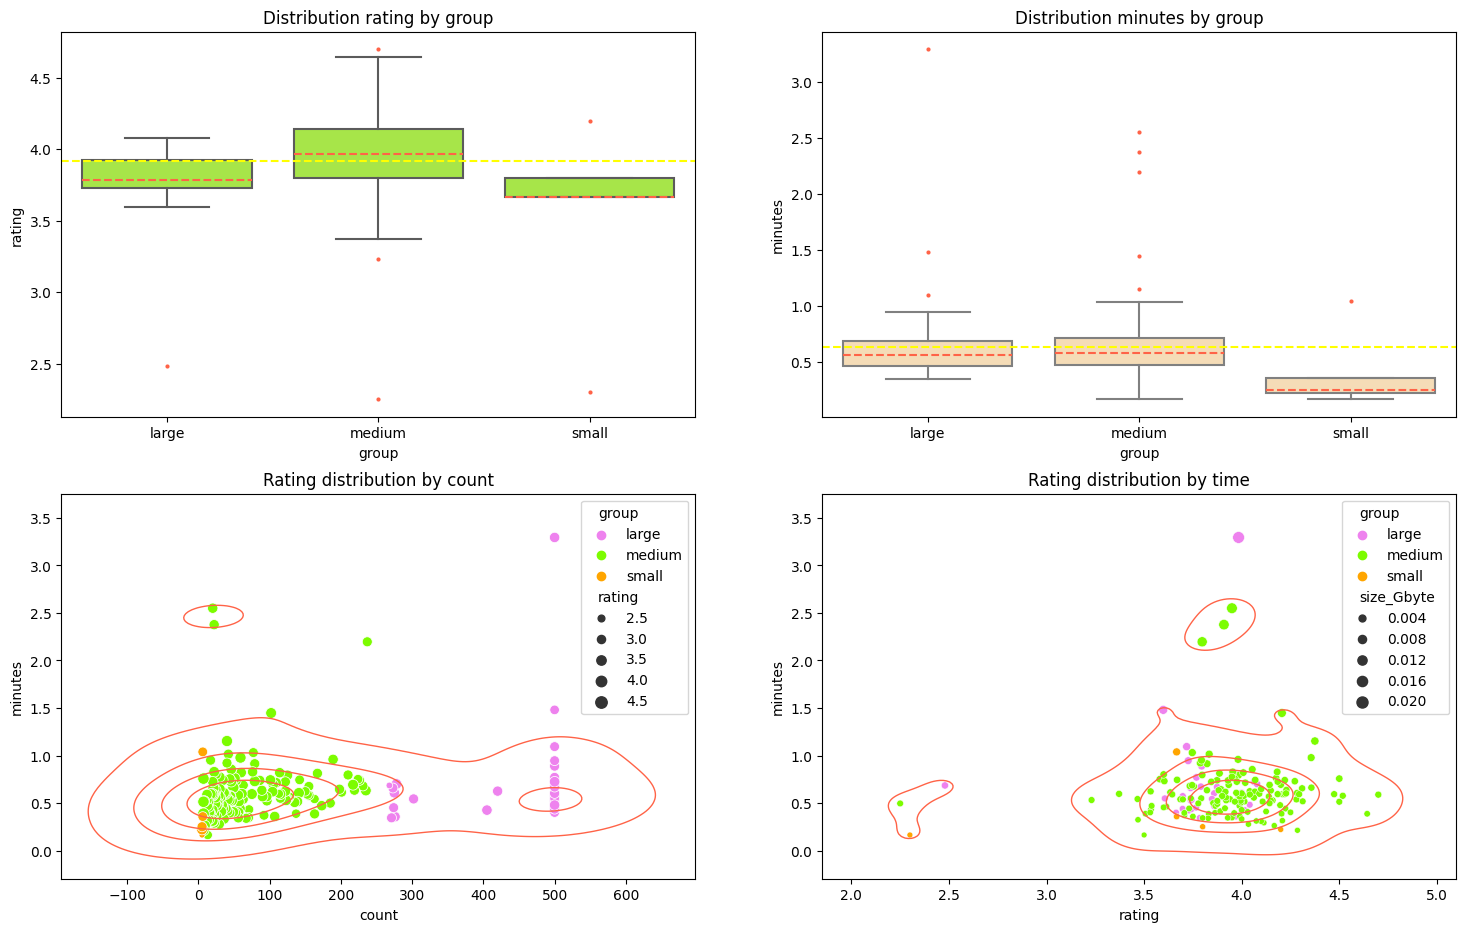

In [15]:
show_aggregation_info(df_pr)

Если смотреть в разрезе группировки по классам можно отметить следующие моменты:
 - по группам птиц, для которых доля превышает 2% в общей структуре, характерен невысокий рейтинг. Как видно из графика 1 75% данных из этой выборки имеет рейтинг не выше среднего всей совокупности данных.
 - большинство аудиофайлов имеет среднюю продолжительность от 30 до 60 секунд. В группе, где представленны файлы с минимальным наполнением длина аудиофайла менее 20 секунд.

Сгруппируем теперь по авторам.

In [16]:
df_author = get_aggregation(df, 'author')
df_author.head()

,proportion,rating,minutes,size_Gbyte,count,group
author,,,,,,
José Carlos Sires,0.037410,3.008197,1.040640,0.007443,915,large
Albert Lastukhin,0.037328,3.648412,0.829116,0.005930,913,large
Stanislas Wroza,0.030459,3.898658,0.585688,0.004189,745,large
Mike Nelson,0.027434,3.891207,0.454360,0.003250,671,large
Bram Piot,0.021219,3.866089,0.630730,0.004511,519,large


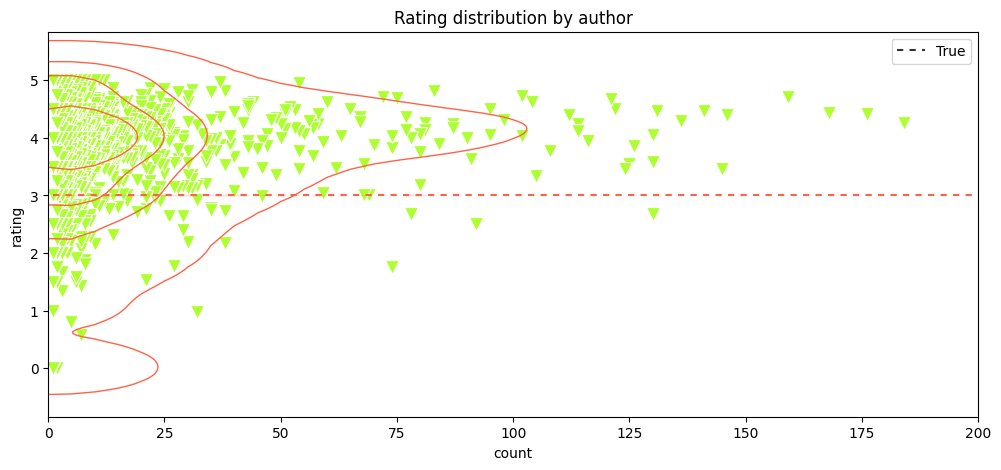

In [17]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df_author['count'], y=df_author['rating'],  color='greenyellow', marker = 'v', s = 100)
sns.kdeplot(x=df_author['count'], y=df_author['rating'], levels=5, color='tomato', linewidths=1)
sns.lineplot(x = df_author['count'], y=3, style=True, dashes=[(3,3)], color = 'tomato')
plt.title('Rating distribution by author')
plt.xlim(0, 200)
plt.show()

Большая часть авторов публикует до 30 аудиозаписей на портале. Те аторы, которые публикуют большое количество данных, как правило, имеют выше 3,7.

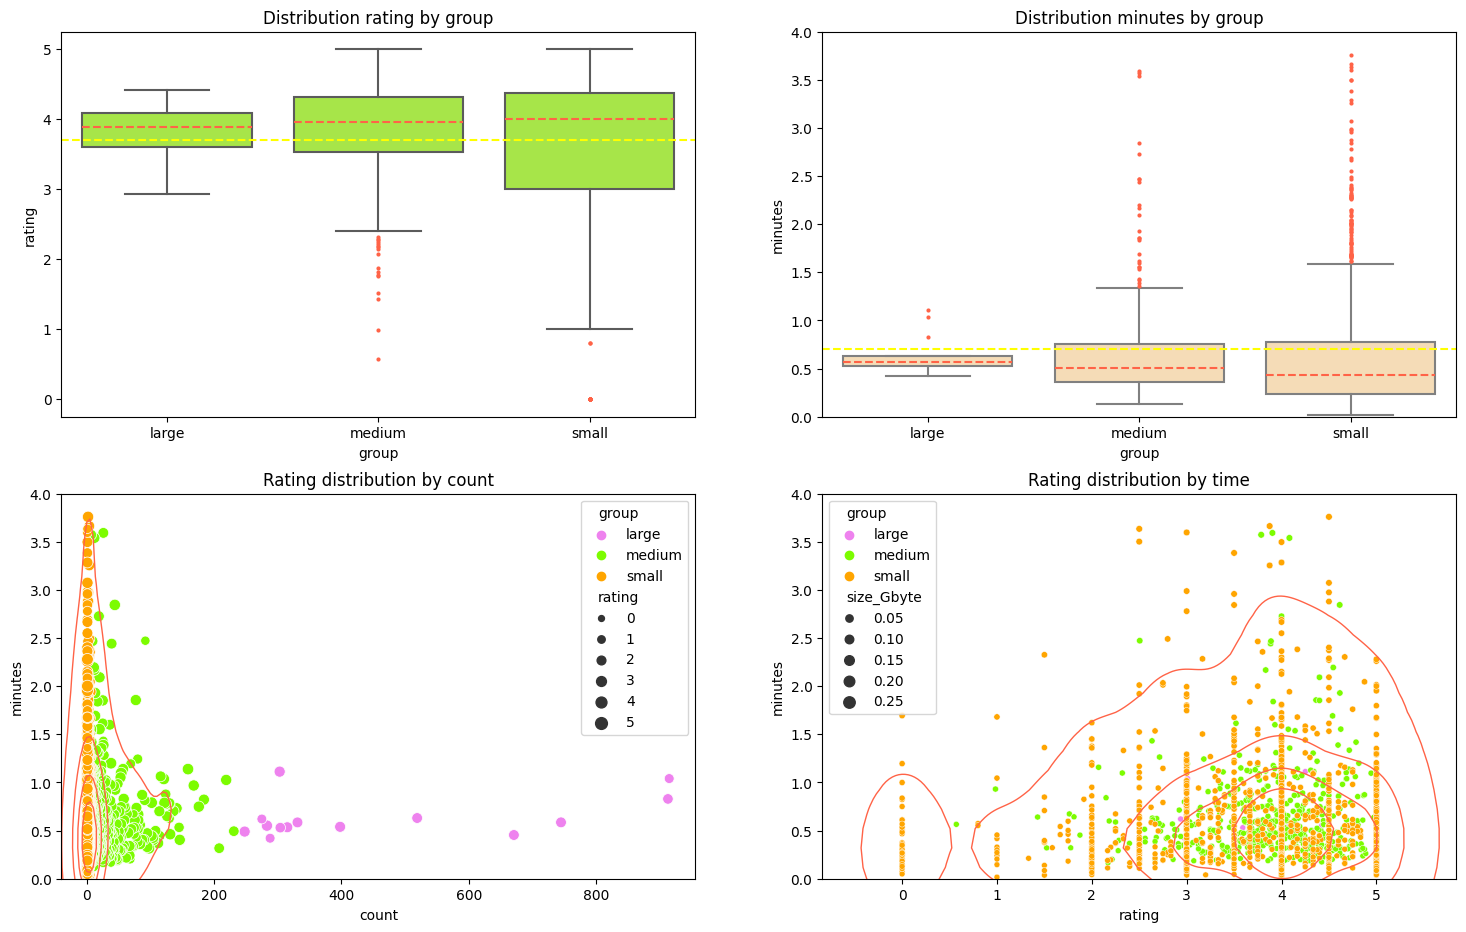

In [18]:
show_aggregation_info(df_author, lim=4)

 - наиболее многочисленная группа авторов, та у которой доля в структуре составляет менее 0,1%. В этой же группе наибольший разброс в оценках и длительности аудиозаписей. 
 - авторы с большим количеством публикуемых аудиозаписей выкладывают как правило ролики с продолжительностью до минуты.

In [19]:
def show_category(df, column):

    sns.despine(plt.figure(figsize=(20, 5)), left=True, bottom=True)
    
    colors = ['navajowhite', 'lawngreen', 'yellow', 'coral']
    
    ax = plt.subplot(1, 2, 1)
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(color='greenyellow', ax=ax)
    ax.set_title(f'Distribution birds of continents by {column}')
    gdf.plot(ax=ax, marker='o', column=df[column], cmap='spring', markersize=1.2, legend=True,
             legend_kwds={'loc':'lower left', 'markerscale':1,'frameon': False, 'title_fontsize':'medium', 'title': f'{column}', 'bbox_to_anchor':(1, 0., 0.5, 0.5),'fontsize':'small'})

    ax = plt.subplot(1, 2, 2)
    ax.set_title(f'Group {column} structure')
    sizes = df[column].value_counts(normalize = True)
    labels = df[column].value_counts().index
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=60, colors = sns.color_palette(colors, 9).as_hex())
    plt.show()

Посмотрим еще на категориальные данные.
Как видно из графиков, маркировка записей тегами не является обязательной. Данных не достаточно, чтобы делать на их основе какие-либо выводы. 

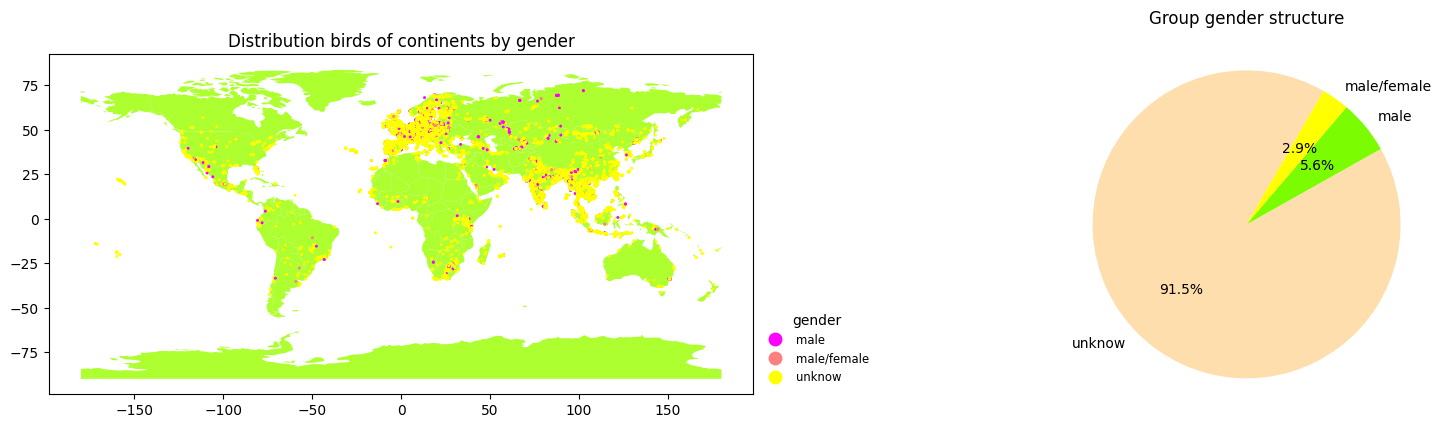

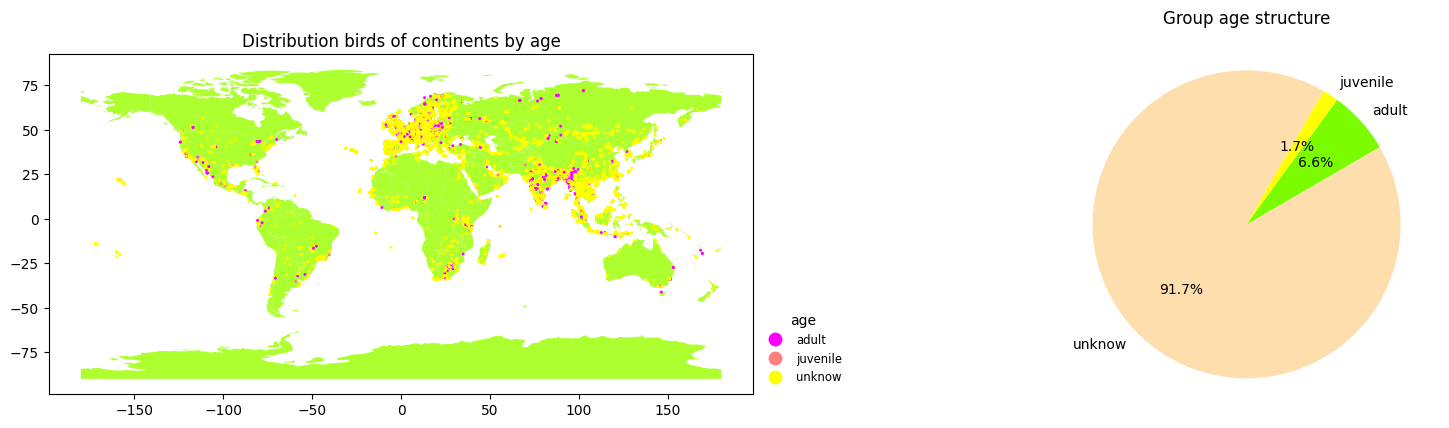

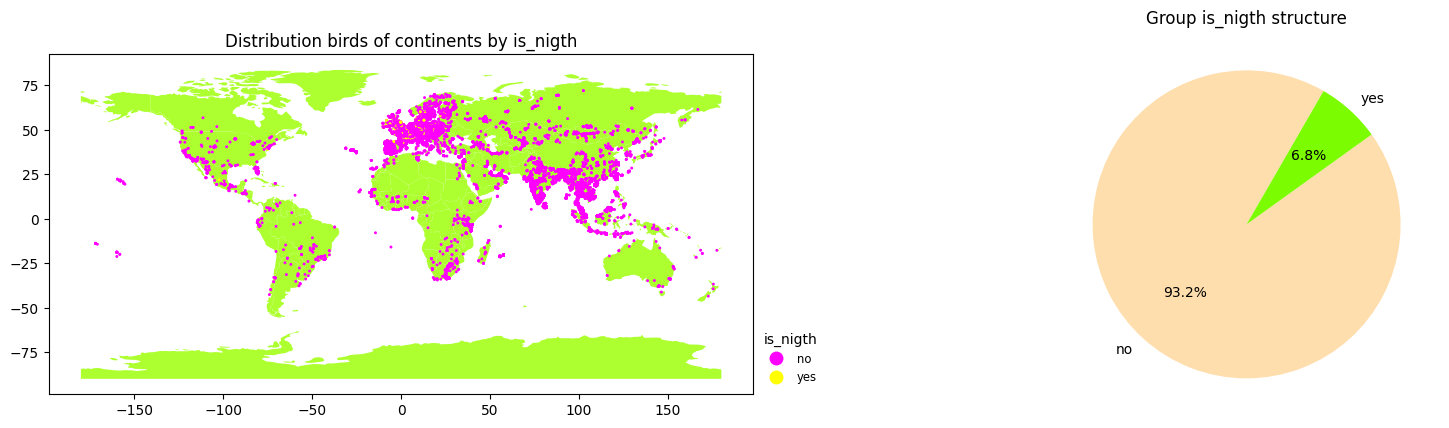

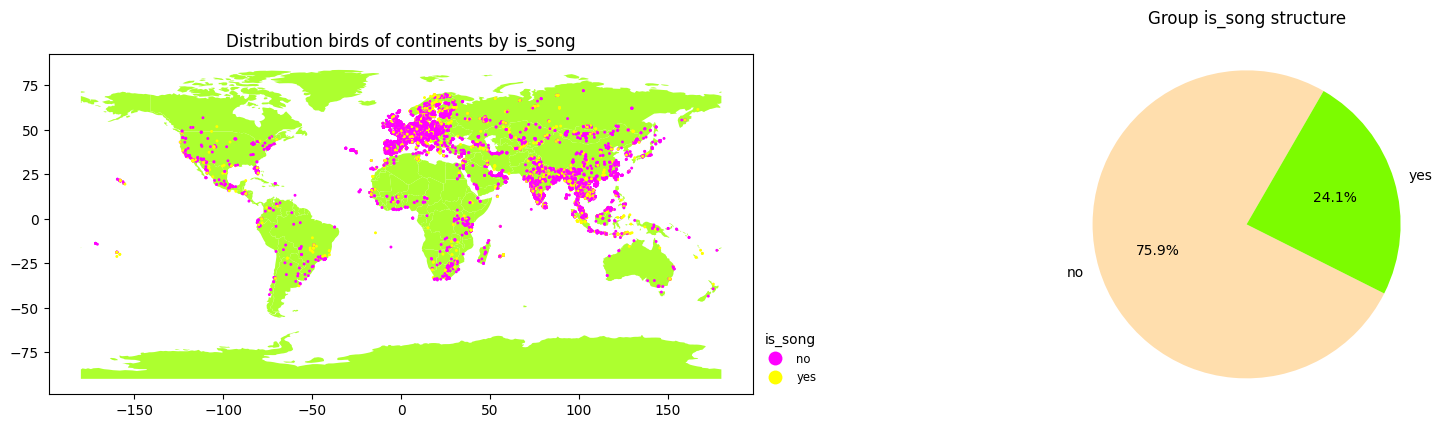

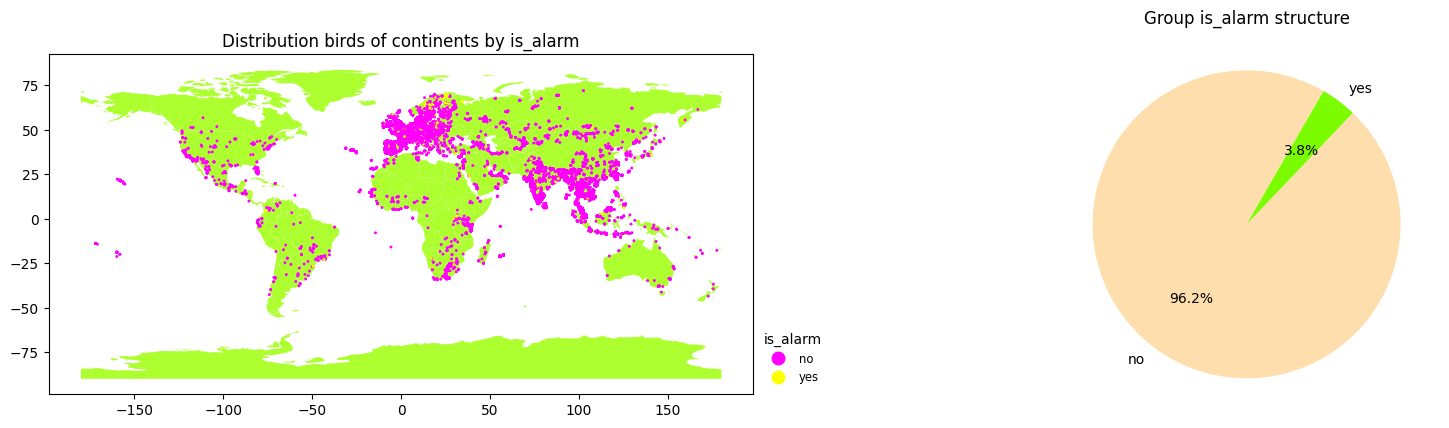

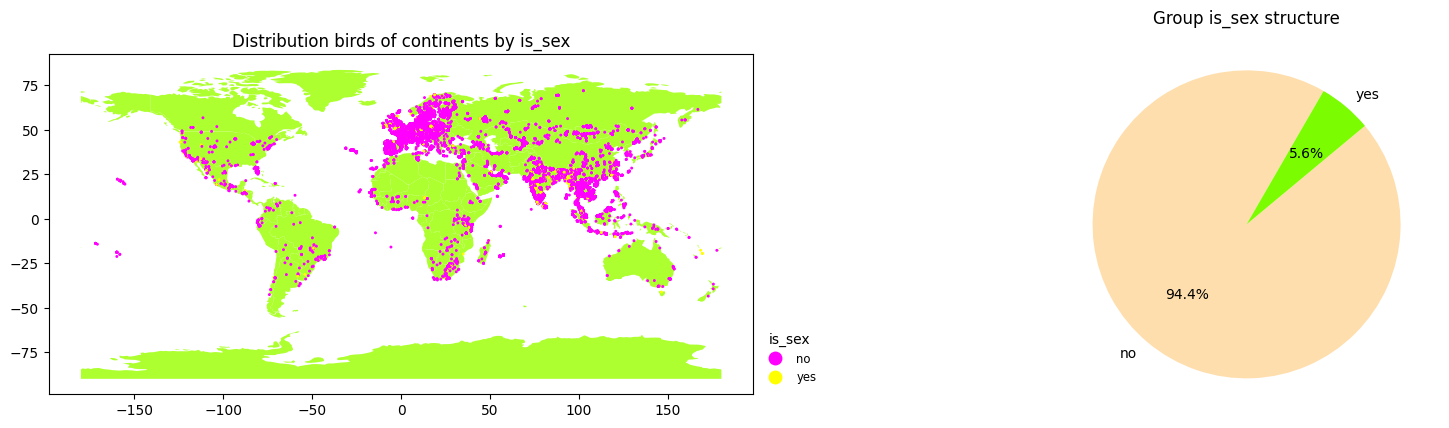

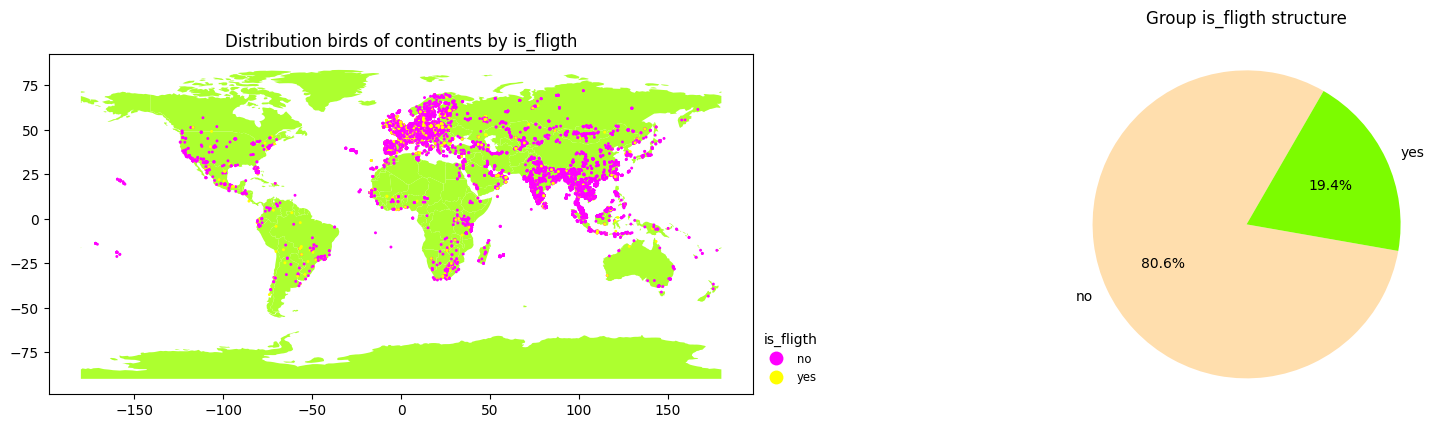

In [20]:
category_columns = ['gender', 'age','is_nigth', 'is_song', 'is_alarm', 'is_sex', 'is_fligth']

for column in category_columns:
    show_category(df, column)